In [1]:
import pandas as pd
import spacy
nlp = spacy.load('en')
import glob, os
from random import shuffle
%matplotlib inline

### Read files

In [2]:
# load the dataframes from PS1
df = pd.read_pickle('/Users/paulinagrnarova/RobotJudge/PS1/df_large') 
normalized_df = pd.read_pickle('/Users/paulinagrnarova/RobotJudge/PS1/normalized_df_large')
df.head()

,id,text,doc,normalized_doc,reversed
2,1924_X2S1VV.txt,"JOHNSON , District Judge. Appellees, hereinaf...","( , JOHNSON, ,, District, Judge, ., Appellees,...","[johnson, district, judg, appelle, hereinaft, ...",1
7,1925_X3IJOJ.txt,PER CURIAM. The order appealed from is a plai...,"( , PER, CURIAM, ., The, order, appealed, from...","[per, curiam, order, appeal, plain, violat, se...",0
20,1925_X3JG8P.txt,"RUDKIN , Circuit Judge. This is an appeal fro...","( , RUDKIN, ,, Circuit, Judge, ., This, is, an...","[rudkin, circuit, judg, appeal, order, allow, ...",1
21,1925_X3JGBE.txt,"HOUGH , Circuit Judge (after stating the fact...","( , HOUGH, ,, Circuit, Judge, (, after, statin...","[hough, circuit, judg, state, fact, sever, mat...",0
22,1925_X3JGF3.txt,"HAND , Circuit Judge (after stating the facts...","( , HAND, ,, Circuit, Judge, (, after, stating...","[hand, circuit, judg, state, fact, case, mr, j...",1


### Train a logistic regression model

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(normalized_df, df['reversed'], test_size=0.2)

In [8]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [10]:
params = {'C':[.1,1,10,11], 'penalty':['l2', 'l1']}
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(log_reg,params,n_jobs=-1, cv=5, iid=True)
grid.fit(X_train, y_train)
print grid.best_params_
log_reg = grid.best_estimator_

{'penalty': 'l1', 'C': 1}


### Use cross_val_predict() to form model prediction for each observation. Construct a confusion matrix for the predictions

In [11]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(log_reg,X_test,y_test)

In [12]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(confusion_matrix(y_test, y_pred))

[[15 26]
 [26 33]]


### Report precision_recall and roc curves

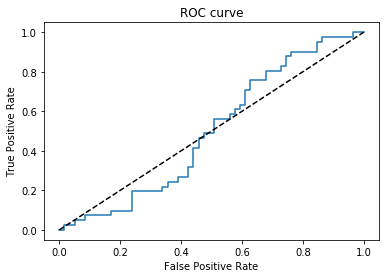

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

#log_reg.set_params(C=0.1, penalty='l1') # already set
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)
dec=log_reg.decision_function(X_test)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, dec, pos_label="0")
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

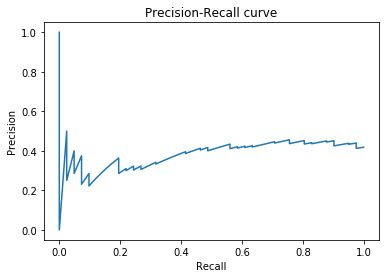

In [14]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, dec, pos_label="0")
plt.plot(recall, precision)
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Report the calibration plot

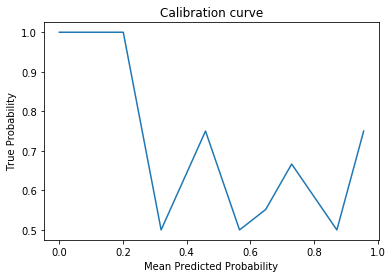

In [15]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, dec, n_bins=10, normalize=True)
plt.plot(prob_pred, prob_true)
plt.title('Calibration curve')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Probability')
plt.show()

In [38]:
from sklearn.metrics import accuracy_score, f1_score
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)
print "Accuracy train"
print accuracy_score(y_train, y_pred_train, normalize=True)
print "Accuracy test"
print accuracy_score(y_test, y_pred_test, normalize=True)
print "F1 train"
print f1_score(y_train, y_pred_train, average="macro")
print "F1 test"
print f1_score(y_test, y_pred_test, average="macro")

Accuracy train
0.975
Accuracy test
0.47
F1 train
0.9740636995538956
F1 test
0.42832488404702834


### Read in log_cites and connect them to df (note that the n-grams are already scaled from PS1)

In [16]:
outcomes = {}
judge_ids = {}
log_cites = {}

metadata = pd.read_csv("/Users/paulinagrnarova/RobotJudge/PS2/case_metadata.csv")
metadata = metadata.dropna(axis='index', how='any') 

def get_caseid(doc):
    return doc.split("_")[1].split('.')[0]
df['caseid']=df['id'].apply(get_caseid)

for caseid, outcome, judgeid, year, logcites in metadata.values:
    outcomes[caseid] = outcome
    judge_ids[caseid] = int(judgeid)
    log_cites[caseid] = logcites


In [17]:
# Add the logcites to the dataframe
def get_logcites(doc):
    if doc in log_cites:
        return log_cites[doc]
    else:
        return 0.0
df['logcites']=df['caseid'].apply(get_logcites)
df.head()

,id,text,doc,normalized_doc,reversed,caseid,logcites
2,1924_X2S1VV.txt,"JOHNSON , District Judge. Appellees, hereinaf...","( , JOHNSON, ,, District, Judge, ., Appellees,...","[johnson, district, judg, appelle, hereinaft, ...",1,X2S1VV,0.000000
7,1925_X3IJOJ.txt,PER CURIAM. The order appealed from is a plai...,"( , PER, CURIAM, ., The, order, appealed, from...","[per, curiam, order, appeal, plain, violat, se...",0,X3IJOJ,0.000000
20,1925_X3JG8P.txt,"RUDKIN , Circuit Judge. This is an appeal fro...","( , RUDKIN, ,, Circuit, Judge, ., This, is, an...","[rudkin, circuit, judg, appeal, order, allow, ...",1,X3JG8P,0.693147
21,1925_X3JGBE.txt,"HOUGH , Circuit Judge (after stating the fact...","( , HOUGH, ,, Circuit, Judge, (, after, statin...","[hough, circuit, judg, state, fact, sever, mat...",0,X3JGBE,0.000000
22,1925_X3JGF3.txt,"HAND , Circuit Judge (after stating the facts...","( , HAND, ,, Circuit, Judge, (, after, stating...","[hand, circuit, judg, state, fact, case, mr, j...",1,X3JGF3,0.000000


### Form model predictions from an elastic net

In [18]:
X_train_lc, X_test_lc, y_train_lc, y_test_lc = train_test_split(normalized_df, df['logcites'], test_size=0.2)

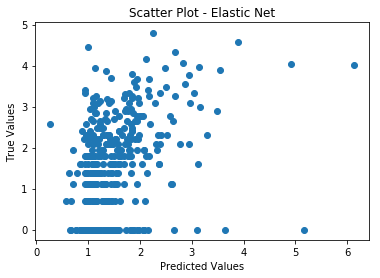

In [19]:
from sklearn.linear_model import ElasticNet
elast = ElasticNet(alpha=0.1)
y_pred_lc = cross_val_predict(elast, X_train_lc, y_train_lc, cv=5)

plt.scatter(y_pred_lc, y_train_lc)
plt.title('Scatter Plot - Elastic Net')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

### Train LDA and produce word clouds

In [21]:
# Create term dictionary
from gensim import corpora
dictionary = corpora.Dictionary(normalized_df)

# Create document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in normalized_df]
from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics=10, 
               id2word = dictionary, passes=30)
lda.show_topics(formatted=False)

[(0,
  [(u'#', 0.28054048453175773),
   (u'section', 0.0564627796626974),
   (u'law', 0.031569415682440725),
   (u'feder', 0.029299824013142867),
   (u'id', 0.028559792226021494),
   (u'tax', 0.02050449788587254),
   (u'amend', 0.02048153139917559),
   (u'claim', 0.02031885297912796),
   (u'usca', 0.015980083530397947),
   (u'co', 0.015980013466929677)]),
 (1,
  [(u'act', 0.1661128364549269),
   (u'#', 0.09930730384090512),
   (u'v', 0.04479714726644413),
   (u'new', 0.04172650418630736),
   (u'york', 0.035811889813073594),
   (u'revenu', 0.026933964467931244),
   (u'utah', 0.02100792718705349),
   (u'pie', 0.018052976321575008),
   (u'code', 0.018051446752584344),
   (u'intern', 0.015095687954792745)]),
 (2,
  [(u'#', 0.5980768460424278),
   (u'v', 0.027603178878115087),
   (u'sct', 0.014529737862971992),
   (u'f3d', 0.010111319904696159),
   (u'page', 0.008663967814448066),
   (u'citat', 0.007887194958941019),
   (u'us', 0.006777066697812859),
   (u'n', 0.0056669430581645095),
   (u'

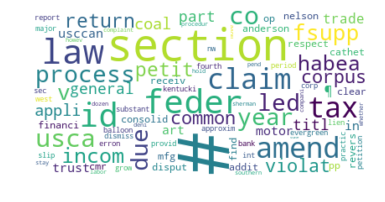

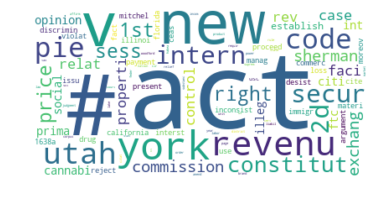

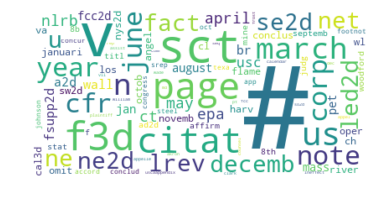

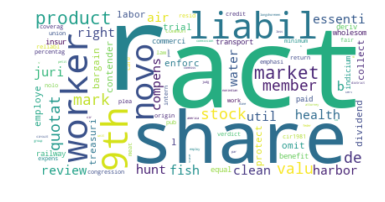

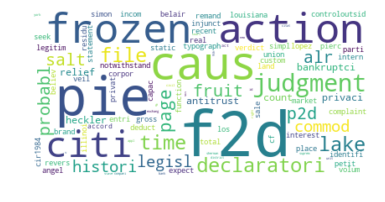

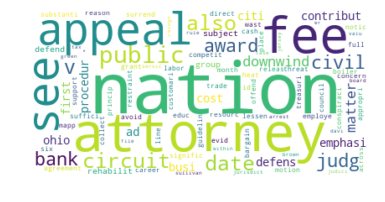

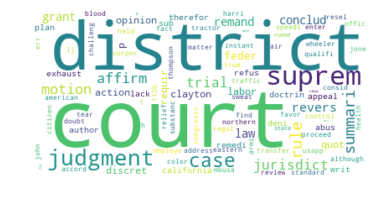

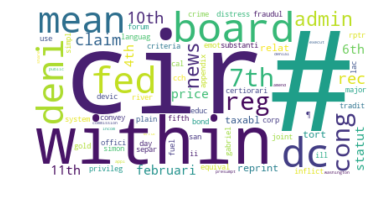

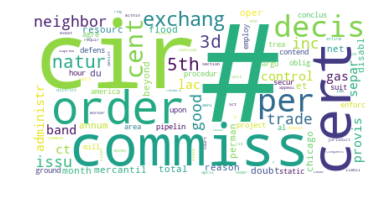

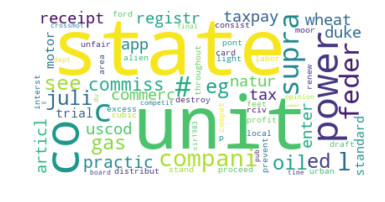

In [22]:
from numpy.random import randint
from wordcloud import WordCloud

for i, weights in lda.show_topics(num_topics=-1, num_words=100, formatted=False):
    
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(dict(weights))

    plt.clf()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()
    


### Replicate logistic regression model in Keras

(400, 1000)
(400,)
Train on 360 samples, validate on 40 samples
Epoch 1/30
360/360 [==============================] - 0s - loss: 0.9631 - acc: 0.4806 - val_loss: 0.8228 - val_acc: 0.5750
Epoch 2/30
360/360 [==============================] - 0s - loss: 0.8915 - acc: 0.5056 - val_loss: 0.8043 - val_acc: 0.6250
Epoch 3/30
360/360 [==============================] - 0s - loss: 0.8375 - acc: 0.5167 - val_loss: 0.7952 - val_acc: 0.6000
Epoch 4/30
360/360 [==============================] - 0s - loss: 0.7950 - acc: 0.5333 - val_loss: 0.7889 - val_acc: 0.5750
Epoch 5/30
360/360 [==============================] - 0s - loss: 0.7568 - acc: 0.5722 - val_loss: 0.7892 - val_acc: 0.5750
Epoch 6/30
360/360 [==============================] - 0s - loss: 0.7214 - acc: 0.6028 - val_loss: 0.7908 - val_acc: 0.5750
Epoch 7/30
360/360 [==============================] - 0s - loss: 0.6888 - acc: 0.6306 - val_loss: 0.7926 - val_acc: 0.6000
Epoch 8/30
360/360 [==============================] - 0s - loss: 0.6618 - a

Text(0,0.5,u'accuracy')

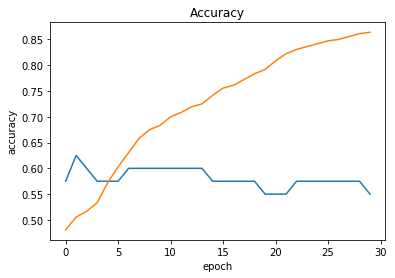

In [30]:
from keras.models import Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout
from keras.regularizers import l2

print X_train.shape
print y_train.shape

model = Sequential() 
model.add(Dense(output_dim=1, input_dim=X_train.shape[1], activation='sigmoid', W_regularizer=l2(0.01))) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelfit = model.fit(X_train.values, y_train.values, batch_size=128, nb_epoch=30, validation_split=.1, shuffle=True)
loss_and_metrics = model.evaluate(X_test.values, y_test.values, batch_size=32)

# Print loss, accuracy and plot accuracy
print ("\n The accuracy is: " + str(loss_and_metrics[1]))
print loss_and_metrics
plt.plot(modelfit.epoch, modelfit.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(modelfit.epoch, modelfit.history['acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')


### Deeper network

Train on 360 samples, validate on 40 samples
Epoch 1/30
360/360 [==============================] - 0s - loss: 1.0064 - acc: 0.4444 - val_loss: 0.7740 - val_acc: 0.5000
Epoch 2/30
360/360 [==============================] - 0s - loss: 0.9588 - acc: 0.4444 - val_loss: 0.7573 - val_acc: 0.4500
Epoch 3/30
360/360 [==============================] - 0s - loss: 0.8991 - acc: 0.4778 - val_loss: 0.7445 - val_acc: 0.4500
Epoch 4/30
360/360 [==============================] - 0s - loss: 0.8260 - acc: 0.4833 - val_loss: 0.7322 - val_acc: 0.4250
Epoch 5/30
360/360 [==============================] - 0s - loss: 0.8298 - acc: 0.4972 - val_loss: 0.7241 - val_acc: 0.4000
Epoch 6/30
360/360 [==============================] - 0s - loss: 0.7919 - acc: 0.5194 - val_loss: 0.7181 - val_acc: 0.4000
Epoch 7/30
360/360 [==============================] - 0s - loss: 0.7529 - acc: 0.5389 - val_loss: 0.7158 - val_acc: 0.4000
Epoch 8/30
360/360 [==============================] - 0s - loss: 0.7341 - acc: 0.5361 - val_lo

Text(0,0.5,u'accuracy')

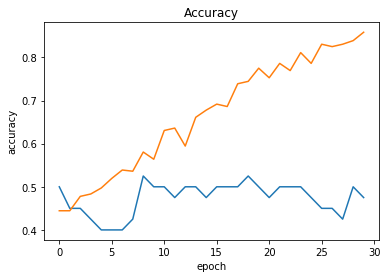

In [37]:
model = Sequential() 
model.add(Dense(60, input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(60))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(60))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelfit = model.fit(X_train.values, y_train.values, batch_size=128, nb_epoch=30, validation_split=.1, shuffle=True)
loss_and_metrics = model.evaluate(X_test.values, y_test.values, batch_size=32)

# Print loss, accuracy and plot accuracy
print ("\n The accuracy is: " + str(loss_and_metrics[1]))
print loss_and_metrics
plt.plot(modelfit.epoch, modelfit.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(modelfit.epoch, modelfit.history['acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')